# Homework # 1: Audio Digital Classification

In this homework you will master all the basic skills needed to work with audio classification. The goal is to implement a simple speech recognition system which can classify spoken digits. We will work with the [**AudioMNIST** ](https://arxiv.org/pdf/1807.03418.pdf) dataset (audio equivalent of the MNIST dataset). 

To construct an audio classifier you will need to implement dataloading, data preprocessing, augmentation and design a neural network which works well with audio data. In this homework you will:
* Learn how to use `torchaudio` as a library for working with audio in conjunction with `torch`
* Experiment with different feature representations of the audio signal in practice
* Develop an audio classification model based on recurrent networks
* Test the trained model on real data (on your own voice)


### Task Structure 
This homework is structured as follows:

* Voice Activity Detection (VAD): Here we will create a custom test-set using either your own voice or some pre-recorded data. You will implement a simple energy-based VAD system that you can partition your data into separate digits.
* Dataloading: Here the goal is to learn how to preprocess an audio dataset into a convenient format. Additionally, here you can also add data augmentation, which can improve the quality of your model.
* Deep Leaening: This is the meat of the exercize. Here you will implement a simple audio classification neural network and train it in on the AudioMNIST dataset. Points will be awarded based on the performance of your model. 


### Grading criteria

```
[ ] (4 point)  Implement energy VAD for audio splitting
[ ] (2 point)  Implement data preprocessing
[ ] (3 point)  Implement batching
[ ] (6 points) Train classification model (> 95% accuracy on validation)
[ ] (6 points) Achieve good test-score on our side (> 95% accuracy on hidden sample)
[ ] (4 points) Answer questions
```

### Submitting results

The results of this task are two artifacts:
1. this Jupiter Notebook (`.ipynb`) with completed cells
2. checkpoint of the `model.path` model on the "best" iteration

Save the artifacts to a directory named `{your last name}_{your first name}_hw1` and pack them in `.zip` archive.

## *Final score will be computed as number of points multiplied by 0.08 in purpose to set upper bound for your grade as 2*!

# Setup

#### Dockerfile
```
FROM nvidia/cuda:10.1-devel-ubuntu18.04

RUN apt-get update && apt-get install -y sox python3.7-dev python3.7-distutils curl
RUN ln -s /usr/bin/python3.7 /usr/bin/python
RUN ln -s /usr/bin/pip3 /usr/bin/pip

RUN curl --silent --show-error --retry 5 https://bootstrap.pypa.io/get-pip.py | python3.7
# torch==1.7.1+cu101 if GPU exists
RUN pip install torch==1.7.1 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
RUN pip install numpy==1.17.5 matplotlib==3.3.3 tqdm==4.54.0 jupyter
```

#### Bulding docker image

```
docker build -t hw1 -f Dockerfile .
```

#### Running docker container

```
# nvidia-docker if GPU exists
docker run -it --rm \
    --user $(id -u ${USER}):$(id -g ${USER}) \
    -p 8888:8888 \
    --volume $(pwd):$(pwd) \
    --workdir $(pwd) --env HOME=$(pwd) \
    --name hw1 hw1:latest jupyter notebook --ip 0.0.0.0
```

### Installing libraries

We will work with `torch` version `1.7.1` (with the corresponding version of `touchaudio`).

While the installation is in progress, you can run your eyes through the [documentation](https://pytorch.org/audio/stable/transforms.html) to `torchaudio` – from this library, we will only need a few transforms, as well as audio loading functions.

In [1]:
! apt-get update && apt-get install -y sox python3.7-dev python3.7-distutils curl

In [2]:
! pip install \
    torch==1.7.1+cu101 \
    torchvision==0.8.2+cu101 \
    torchaudio==0.7.2 \
    -f https://download.pytorch.org/whl/torch_stable.html

! pip install numpy==1.17.5 matplotlib==3.1.3 tqdm==4.54.0

### Obtaining AudioMNIST dataset 
<!-- 0️⃣1️⃣2️⃣3️⃣4️⃣5️⃣6️⃣7️⃣8️⃣9️⃣ -->

To get the dataset, clone the repository (`~1Gb`) running the code below:

In [3]:
! git clone https://github.com/soerenab/AudioMNIST

In [1]:
import os

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
import shutil

from typing import List, Tuple
from glob import glob

from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, Audio
%matplotlib inline

DIGIT_NAMES = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

/home/ttsrnd/knyazev/envs/rnd_train_venv/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Select GPU

If you run this Jupyter Notebook on a computer with a video card (**GPU**), you need to specify which card you want to work with, and you also need to make sure that `torch` sees it. 

If you *really* want, you can do your homework without using a video card, but then the training will take long time.

**Tip**: if the video card is an exhausted resource (i.e. you have a usage quota, or you pay for usage), then it is better to **debug** training without the GPU: to make sure that the model does not crash with an error, and the loss decreases in the first iterations.

In [3]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

if torch.cuda.is_available():
    print('GPU found! 🎉')
    device = 'cuda'
else:
    print('Only CPU found! 💻')
    device = 'cpu'

GPU found! 🎉


# Audio Partitioning via Voice Activity Detection (4 point) 

Here you will create a custom test set for this homework by recording and partitioning your own voice using Voice Activity Detection (VAD).

### Grading criteria - for **ASSESSORS**

```
[ ] (1 point)  Energy is correctly highlighted
[ ] (3 point)  Digits are clearly separated
```

### Prepare the set for testing

The data for training and validation of your digit classification model will be taken from the `AudioMNIST` dataset. But as you know, there is a risk of overfitting not only on training set, but also on validation set. Therefore, for the purity of the experiment, we will evaluate your model on real data - your own voice!

You can record your own (or someone else's) voice speaking out the numbers, so you will have a real mini-dataset for testing. You will need this data  - You will test your model on your **own** testing set. 👀

To record your voice, you can use web-sites like [this](https://voice-recorder-online.com) or you can do this via the command line (you need the `sox` utility):

```
rec recording.wav trim 0 10   # record a 10-second audio fragment
of play recording.wav         # listen to it
```

For best results, say all the digit clearly at least ten times. Eg `[0, 1, 2, ... , 9, 0, 1, ... 9, 0, ... , 9]`

### Preprocessing

The recording may differ not only in format (be `mp3`, `ogg`), but in sampling rate (`22050Hz`, `44100Hz`), being a stereo recording, and so on. 

To bring the record to the unified format we need:

In [4]:
# -> 16kHz, 16bit, mono
! sox recording.wav -r 16000 -b 16 -c 1 recording_16kHz.wav

x, sr = torchaudio.load('recording_16kHz.wav')
x = x[0].numpy()

print(", ".join(DIGIT_NAMES))
display(Audio(x, rate=sr))

zero, one, two, three, four, five, six, seven, eight, nine


### Voice Activity Detection (1 point)

You need to break this record into fragments, each of which would contain audio with the pronunciation of **only one** digit. Let's use the energy ⚡️ VAD to do this!

**Calculate** the energy of the signal across a series of __windows__ (choose the window size $T$ however you like) and look at its plot.

The energy of a discrete audio sequence $x_{1:T}$ of length $T$ is defined as:

$$
\mathrm{E} = \sum_{t=1}^T |x_t|^2
$$

You may find it useful to visualize signal energy in decibels.

In [162]:
def plot_signal_energies(x, sr, energies_db, window_size=512, intervals=None):
    fig, ax = plt.subplots(figsize=(len(x) / sr, 2.5))
    ax.plot(x, color='#20639b', label='audio signal')
    plt.xticks(np.arange(0, len(x), sr), np.int32(np.arange(0, len(x), sr) / sr))
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel('time [s]')
    plt.ylabel('amplitude')
    plt.ylim([-0.51, 0.51])
    plt.xlim(-50, len(x) + 50)
    if intervals:
        for a, b in intervals:
            ax.add_patch(patches.Rectangle(
                (a, -0.5), b - a, 50,
                linewidth=2, edgecolor='red', 
                facecolor='none'))

    plt.twinx()
    plt.plot(
        np.linspace(0, len(x), len(energies_db)), energies_db, 
        color='#3caea3', label=f'energy (window size = {window_size})')
    plt.ylabel('Energy [dB]')
    plt.legend(loc='best')
    plt.show()

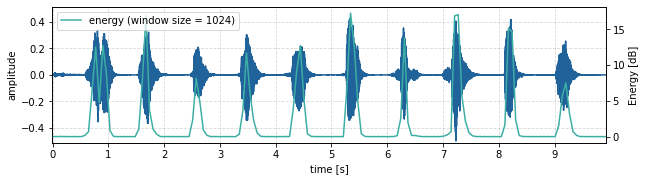

In [163]:
# You can choose the optimal window size empirically
win_size = 1024

x, sr = torchaudio.load('recording_16kHz.wav')
x = x[0].numpy()

energies_db = []
for i in range(len(x) // win_size + 1):
    x_win = x[i * win_size: (i + 1) * win_size]

    # calculate energy of signal fragment
    ################################################################################
    # <YOUR CODE>
    ################################################################################

energies_db = np.array(energies_db)

plot_signal_energies(x, sr, energies_db, win_size)

### Partitioning the Audio (3 point)

Now that you can see when you need a digit and when you don't, I hope you will have no trouble coming up with **a heuristic** for finding the boundaries of spoken words. You will then use this heuristic to parition your audio sequences into individual digits.

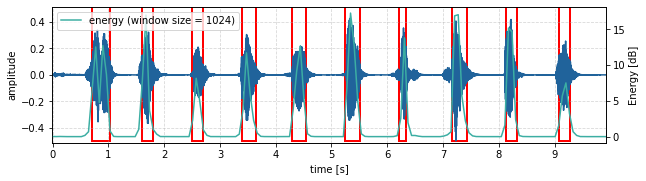

In [178]:
# list of digit intervals [(a_0, b_0), ...]
# where a_i -- first audio sample of spoken word, b_i -- last sample
intervals = []

################################################################################
# <YOUR CODE>
################################################################################

# Visualize where your boundaries are
plot_signal_energies(x, sr, energies_db, win_size, intervals)

We will split the original record into fragments and save them to the directory with the dataset.

In [179]:
test_directory = 'AudioMNIST/data/test'
if not os.path.exists(test_directory):
    os.mkdir(test_directory)

n = 0
for a, b in intervals:
    x_digit = x[a: b]
    path = f'{test_directory}/{n % 10}_test_{n // 10}.wav'
    print(f'"{DIGIT_NAMES[n % 10]}" -> {path}')
    n += 1
    
    torchaudio.save(path, torch.FloatTensor(x_digit), sr)
    display(Audio(path))

"zero" -> AudioMNIST/data/test/0_test_0.wav


"one" -> AudioMNIST/data/test/1_test_0.wav


"two" -> AudioMNIST/data/test/2_test_0.wav


"three" -> AudioMNIST/data/test/3_test_0.wav


"four" -> AudioMNIST/data/test/4_test_0.wav


"five" -> AudioMNIST/data/test/5_test_0.wav


"six" -> AudioMNIST/data/test/6_test_0.wav


"seven" -> AudioMNIST/data/test/7_test_0.wav


"eight" -> AudioMNIST/data/test/8_test_0.wav


"nine" -> AudioMNIST/data/test/9_test_0.wav


# Data Processing Pipeline (5 point)

In this part you will implement the dataloading, preprocessing and batching utilities necessary to train and test your model.


### Grading criteria - for **ASSESSORS**

```
[ ] (2 points) - Data preprocessing - do the features look sensible?
[ ] (3 points) - Batching
```

### Dataloader

The class below (a subclass of `torch.utils.data.Dataset`) holds the logic of loading `AudioMNIST` dataset. All the file handling routines are already written

In [180]:
class AudioMNISTDataset(data.Dataset):
    def __init__(self, directory: str, mode='train'):
        self.mode = mode
        assert mode == 'train' or mode == 'valid' or mode == 'test'
        self.filepaths = []
        self.labels = []
        for filepath in sorted(glob(os.path.join(directory, '*', '?_*_*.wav'))):
            digit, speaker, example_id = os.path.basename(filepath).replace('.wav', '').split('_')
            add = False
            if speaker == 'test' and mode == 'test':
                add = True
            if speaker != 'test' and int(speaker) % 6 == 0 and mode == 'valid':
                add = True
            if speaker != 'test' and int(speaker) % 6 != 0 and mode == 'train':
                add = True
            if add:
                self.filepaths.append(filepath)
                self.labels.append(int(digit))
                
        print(f"Dataset [{mode}]: {len(self.filepaths)} audios")
    
    def __getitem__(self, idx) -> Tuple[torch.FloatTensor, torch.LongTensor]:
        x, sr = torchaudio.load(self.filepaths[idx])
        y = torch.LongTensor([self.labels[idx]])[0]
        
        # Conversion to correct sample rate...
        effects = [
            ['gain', '-n', '0'],        # apply 10 db attenuation
            ['remix', '-'],             # merge all the channels
            ['rate', '16000']
        ]
        x, sr = torchaudio.sox_effects.apply_effects_tensor(x, sr, effects)
        
        # x: audio features
        # y: target digit class
        return x[0], y
    
    def __len__(self):
        return len(self.filepaths)

train_dataset = AudioMNISTDataset('AudioMNIST/data', mode='train')
valid_dataset = AudioMNISTDataset('AudioMNIST/data', mode='valid')
test_dataset = AudioMNISTDataset('AudioMNIST/data', mode='test')

Dataset [train]: 25000 audios
Dataset [valid]: 5000 audios
Dataset [test]: 10 audios


#### Choosing a Representation  (2 point)

You could use the waveform itself as an audio representation (features), **but** as you know from the lecture (*DSP Basics*), this is not the best representation for many tasks. You may find it useful to look up the following transforms:

`torchaudio.transforms.Spectrogram`

`torchaudio.transforms.MelSpectrogram`

`torchaudio.transforms.AmplitudeToDB`

`torchaudio.transforms.MFCC`

You will be able to return to this stage many times while doing you homework, so iterate from simple representations to sophisticated ones.

In [344]:
#!L
# For train you can use SpecAugment data aug here.
train_audio_transforms = nn.Sequential(
    ################################################################################

    #Add features transformations here
    # <YOUR CODE>
    # Can add data augmentation here!
    # <YOUR CODE>
    ################################################################################
)

test_audio_transforms = nn.Sequential(
    ################################################################################
    #Add feature transformations here
    # <YOUR CODE>
    ################################################################################
)

It's interesting to see what we got...

You may see some interesting points in your audio representation, and **may want to try a different representation**. 🕵️‍ Or return to this later.

visualize dataset for training


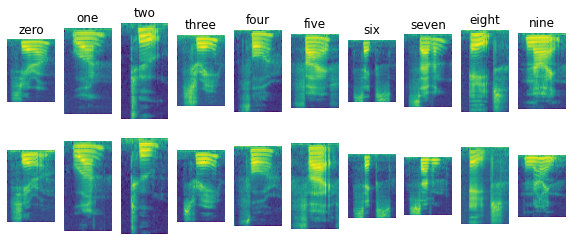

visualize dataset for validation


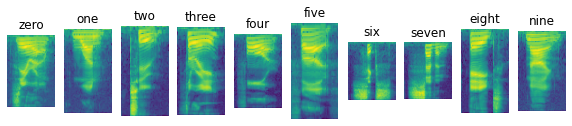

In [345]:
def show_some_examples(dataset, K, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize)
    for digit in range(10):
        indices = np.where(np.array(dataset.labels) == digit)[0]
        for i in range(K):
            x, y = dataset[indices[i]]
            x = test_audio_transforms(x)
            ax = fig.add_subplot(3, 10, digit + i * 10 + 1)
            #rotate
            if i == 0:
                ax.set_title(DIGIT_NAMES[digit])
            ax.imshow(x)
            ax.axis('off')
    plt.show()

print("visualize dataset for training")
show_some_examples(train_dataset, 2)

print("visualize dataset for validation")
show_some_examples(valid_dataset, 1)

# print("visualize dataset for testing")
# show_some_examples(test_dataset, 1)

Can you determine **which number is pronounced** looking at it? If so, then the computer can!

Notice that the audio has different durations because words have different numbers of phonemes and people speak at different speed. Thus, our feature tensors do not have a fixed size either!

```
- Can we bring them to the same size?
- Yes, we can. And it will even work (see the dataset article).
- So why don't we do that?
- This approach has a limited scope. And here's why:
```

* First, in real ASR systems, we do not classify words, but *sounds* (graphemes, phonemes) – they are more difficult to localize and difficult to classify independently. Although, for example, for the task of classifying the sounds of birdsong, this approach would be normal.
* Secondly, convolutional neural networks (actually for which we would like images of the same size) poorly orient in space, since they react to patterns, and may not pay attention to their spatial location. In our problem, the words are quite unique, so they are uniquely identified by a set of sounds (phonemes), so this approach would work. But we're taking a course in **speech recognition and synthesis, not sound classification**. 🙂

### Batch generation class (3 points)
All DL frameworks work with tensors (not lists of tensors). You need to somehow concatenate the individual audio samples into a batch, so that they are processed efficiently. The difficulty is that audio samples have varying length. We suggest you try zero padding, but don't forget to store original length.


In [298]:
from torch.nn.utils.rnn import pad_sequence
class Collate:
    def __init__(self, train=False) -> None:
        super(Collate, self).__init__() 

        self.train = train
    
    def __call__(self, batch: List[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, ... ] :
        """
        :param batch: is a list of tuples of [features, label], where features has dimensions [n_features, length]
        "returns features, lengths, labels: 
              features is a Tensor [batchsize, features, max_length]
              lengths is a Tensor of lengths [batchsize]
              labels is a Tesnor of targets [batchsize]
        """

        features = []
        labels = torch.LongTensor(len(batch)).zero_()
        lengths = torch.LongTensor(len(batch)).zero_()
        ################################################################################
        # <YOUR CODE>
        ################################################################################

        return features, lengths, labels

In [299]:
train_collate_fn = Collate(train=True)
test_collate_fn = Collate(train=False)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, drop_last=True, collate_fn=train_collate_fn)
valid_loader = data.DataLoader(valid_dataset, batch_size=32, shuffle=False,num_workers=4, collate_fn=test_collate_fn)
test_loader =  data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=1, collate_fn=test_collate_fn)

xs, ls, ys = next(iter(train_loader))
print(xs.size(), ls.size(), ys.size())
print(xs.dtype, ls.dtype, ys.dtype)

# Assessment
assert len(xs.size()) == 3
assert xs.size()[0] == ls.size()[0] and ls.size()[0]  == ys.size()[0] 
assert xs.dtype == torch.float32
assert ys.dtype == torch.int64
assert ls.dtype == torch.int64

torch.Size([32, 67, 80]) torch.Size([32]) torch.Size([32])
torch.float32 torch.int64 torch.int64


# Implementing and training your Digit Classifier


### Grading criteria - for **ASSESSORS**

```
[ ] (6 points) Train classification model (> 95% accuracy on validation)
      [ ] (1 point)  > 55% Accuracy
      [ ] (2 points) > 60% Accuracy
      [ ] (3 points) > 65% Accuracy
      [ ] (4 point)  > 75% Accuracy
      [ ] (5 points) > 85% Accuracy
      [ ] (6 points) > 95% Accuracy
[ ] (6 points) Achieve good test-score on our side (> 85% accuracy on hidden sample)
      [ ] (1 point)  > 55% Accuracy
      [ ] (2 points) > 60% Accuracy
      [ ] (3 points) > 65% Accuracy
      [ ] (4 point)  > 75% Accuracy
      [ ] (5 points) > 85% Accuracy
      [ ] (6 points) > 95% Accuracy
```

## The neural network classifier

Write a model for classifying audio. It is desirable to use convolutional layers near the input to process your features and some kind of recurrent layer, such as GRU/LSTM/BiLSTM near the end for making the classification. Start with a simple model and make it more complicated if necessary. 

You can look at some of these papers for inspiration:
* https://arxiv.org/pdf/1904.03288.pdf

## Training, validation, testing 🏋 ️

The minimally sufficient code for training and testing is already written. But feel free to modify the code (but try not to break the compatibility).

**Tips**:
* before you start long-term training, see how your model behaves on the first iterations/epochs
* it is desirable that the training epoch takes less one minute; if longer, maybe your model is too complex
* models converge quickly, so it hardly makes sense to do training more than 100 epochs

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        ################################################################################
        # <YOUR CODE>
        ################################################################################

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        ################################################################################
        # <YOUR CODE>
        ################################################################################
        return x
    
def create_model_and_optimizer(device):
    ################################################################################
    model = Model().to(device)
    optimizer = # CHOOSE YOUR SIDE
    ################################################################################
    return model, optimizer

### Training and Evaluation Functions

In [329]:
# Training and evaluation function
def train(model, optimizer, loader, metrics):
    model.train()
    
    losses = []
    for x, lengths, y in loader:
        x, y = x.to(device), y.to(device)
        lengths = lengths.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x, lengths)
        loss = F.cross_entropy(y_pred, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    metrics['train_loss'].append(np.mean(losses) )


def evaluate(model, loader, metrics, mode):
    model.eval()
    
    losses = []
    cm = np.zeros((10, 10), dtype=np.int32)
    with torch.no_grad():
        valid_losses = []
        for x, lengths, y in loader:
            x, y = x.to(device), y.to(device)
            lengths = lengths.to(device)
    
            y_pred = model(x, lengths)
            loss = F.cross_entropy(y_pred, y)
            losses.append(loss.item())

            y_pred = y_pred.argmax(axis=-1)
            for i in range(len(x)):
                cm[y[i].item(), y_pred[i].item()] += 1
    
    metrics[f'{mode}_loss'].append(np.mean(losses))
    metrics[f'{mode}_accuracy'].append(np.trace(cm) / np.sum(cm))
    metrics[f'{mode}_confusion'].append(cm)


def train_from_scratch(model, optimizer, train_loader, valid_loader, test_loader):
    metrics = {
        'train_loss': [],
        'valid_loss': [],
        'valid_accuracy': [],
        'valid_confusion': [],
        'test_loss': [],
        'test_accuracy': [],
        'test_confusion': []
    }

    best_valid_accuracy = 0.0
    for epoch in tqdm(range(20)):
        train(model, optimizer, train_loader, metrics)
                
        evaluate(model, valid_loader, metrics, 'valid')
        evaluate(model, test_loader, metrics, 'test')
        
        if metrics['valid_accuracy'][-1] > best_valid_accuracy:
            best_valid_accuracy = metrics['valid_accuracy'][-1]
            torch.save({
                'state_dict': model.state_dict(), 
                'metrics': metrics
            }, checkpoint_path)
    
    return metrics

### Main Training and Evaluation Loop

In [330]:
# Training Loop
torch.manual_seed(0)
torch.set_deterministic(True)
np.random.seed(0)

checkpoint_path = 'model.pth'
model, optimizer = create_model_and_optimizer(device)

if os.path.exists(checkpoint_path):
    print(f'Loading model weights from {checkpoint_path}')
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt['state_dict'])
    metrics = ckpt['metrics']
    evaluate(model, valid_loader, metrics, 'valid')
    evaluate(model, test_loader, metrics, 'test')
else:
    print('Training model from scratch..')
    metrics = train_from_scratch(model, optimizer, train_loader, valid_loader, test_loader)

Training model from scratch..


  0%|          | 0/20 [00:00<?, ?it/s]

### Visualization of the results

We will select the model based on the best accuracy value during validation. Let's evaluate the accuracy of the model on the test set.

In [332]:
# Visualization helper function
def plot_accuracies(valid_accuracy, test_accuracy, best_epoch):
    best_valid = valid_accuracy[best_epoch]
    best_test = test_accuracy[best_epoch]
    
    plt.figure(figsize=(7, 3))
    plt.title('Accuracy')
    plt.plot(valid_accuracy, label='valid', color='#20639b')
    plt.plot(test_accuracy, label='test', color='#3caea3')
    plt.grid(linestyle='--', alpha=0.5)
    plt.vlines(best_epoch, 0.6, 1, color='#ed553b', linestyle='--', label='best')
    plt.hlines(best_valid, 0, best_epoch, linestyle='--', color='#555555')
    plt.hlines(best_test, 0, best_epoch, linestyle='--', color='#555555')
    plt.plot(best_epoch, best_valid, marker='o', color='#20639b')
    plt.plot(best_epoch, best_test, marker='o', color='#3caea3')
    plt.text(0, best_valid - 0.02, f"{best_valid:.4f}")
    plt.text(0, best_test - 0.02, f"{best_test:.4f}")
    plt.ylim(0.8, 1.01)
    plt.xlim(0, len(valid_accuracy) - 1)
    plt.xticks(range(len(valid_accuracy)))
    plt.yticks(np.linspace(0.8, 1.0, 11))
    plt.legend()
    plt.show()


def plot_confusion_matrix(cm, names, title='Confusion matrix', normalize=False):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)

    if names is not None:
        tick_marks = np.arange(len(names))
        plt.xticks(tick_marks, names, rotation=45)
        plt.yticks(tick_marks, names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            kwargs = {
                'color': "white" if cm[i, j] > thresh else "black",
                'horizontalalignment': 'center'
            }
            if normalize:
                plt.text(j, i, "{:0.2f}".format(cm[i, j]), **kwargs)
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]), **kwargs)

    accuracy = np.trace(cm) / float(np.sum(cm))

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel(f'Predicted label\naccuracy={accuracy:0.4f}')
    plt.show()

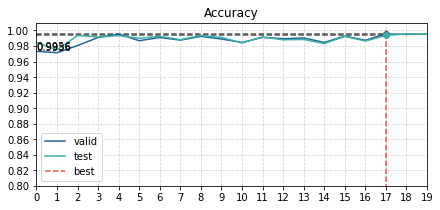

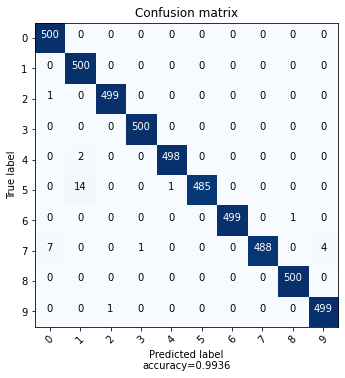

In [333]:
# choosing model by best accuracy on validation set
best = np.argmax(metrics['valid_accuracy'])
best_cm = metrics['test_confusion'][best]

plot_accuracies(metrics['valid_accuracy'], metrics['test_accuracy'], best)
plot_confusion_matrix(best_cm, range(10))

### Regularization and Augmentation

In order to improve the quality of your model, you may want to play around with different regularization and augmentation techniques. Some things to try could be:

* Dropout
* L2 regularization
* BatchNorm / LayerNorm
* Different learning rate schedules

Augmentations are applied to training data to improve the generalization ability of the deep neural model. Think about what augmentations you can apply to the audio, and then check how they work by experiment. You can look at some data augmentation techniques here: 

* [SpecAugment](https://arxiv.org/abs/1904.08779)

For this you may find the following functions useful:

`torchaudio.transforms.FrequencyMasking`

`torchaudio.transforms.TimeMasking`

`torchaudio.transforms.TimeStretch`

In [ ]:
# run experiments here, reuse previously defined functions

# Questions and Conclusions (4 points) 🧑‍🎓

1. Which audio representation did you choose and why?
2. Justify your choice of neural network architecture.
3. Did you use any data augmentation? Justify your choice of augmentation.
4. What did you like in this homework, and what didn't?

```
1. [ ] Your Answer
2. [ ] Your Answer
3. [ ] Your Answer
4. [ ] Your Answer
```